<a href="https://colab.research.google.com/github/peremartra/Rearchitecting-LLMs/blob/main/CH04/CH04_NB0x_Cosine_Similarity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Rearchitecting LLMs
## Surgical Optimization for Hyper-Efficient Models


### Chapter 4: Depth Pruning: Building Smaller and Faster Models
by [Pere Martra](https://github.com/peremartra)

[![LinkedIn](https://img.shields.io/badge/LinkedIn-0077B5?style=flat&logo=linkedin&logoColor=white)](https://www.linkedin.com/in/pere-martra/) [![GitHub](https://img.shields.io/badge/GitHub-100000?style=flat&logo=github&logoColor=white)](https://github.com/peremartra) [![X](https://img.shields.io/badge/X-000000?style=flat&logo=x&logoColor=white)](https://x.com/PereMartra) [![Hugging Face](https://img.shields.io/badge/🤗%20Hugging%20Face-blue)](https://huggingface.co/oopere)

_____
Colab Environment: GPU T4

Models:
* Qwen3-0.6B
_____

In this notebook we explore how to evaluate the contribution of different transformer blocks to the LLM’s objective using a dataset.

To do this, we use cosine similarity between the input and the output of the transformer block. The lower the similarity, the greater the modification that block has introduced to the data.

Blocks with higher similarity between input and output will be the candidates to be removed from the model.


# Setting up notebook

In [1]:
!pip install -q \
      "torch==2.8.0+cu126" \
      "transformers==4.55.4" \
      "accelerate==1.10.1" \
      "lm_eval==0.4.9.1" \
      "sentencepiece==0.2.1" \
      "sentence-transformers==5.1.0" \
      "optipfair==0.1.5"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 39.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 25.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 483.4/483.4 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.9/44.9 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.6/293.6 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 3.9 MB/s eta 0:00:00
   

In [2]:
import torch
import torch.nn.functional as F
from transformers import AutoModelForCausalLM, AutoTokenizer
from datasets import load_dataset
from torch.utils.data import DataLoader
from tqdm import tqdm
import numpy as np

In [3]:
# Check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Using device: cuda
GPU: Tesla T4


## Load Model

In [ ]:
MODEL_NAME = 'Qwen/Qwen3-0.6B'
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    torch_dtype=torch.float16,
    device_map="auto"
)
model.eval()

## Load Datasets

In [5]:
RECOVERY_SAMPLES = 100
BATCH_SIZE = 8
MAX_LENGTH = 512

We’re going to use two different datasets to visualize how some layers are more important than others depending on the data being used.

* **Wikitext**: Contains highly complex text. To process this kind of text, the model needs to rely on its deeper layers to understand context, semantic relations, and complex grammatical structures.
* **SMS Spam**: A completely different dataset, made up of short sentences with simple and direct language. It doesn’t require deep semantic understanding.


In [ ]:
datawiki = load_dataset('wikitext', 'wikitext-2-raw-v1', split=f'train[:100]')

datasms = load_dataset('sms_spam', split=f'train[:100]')

In [7]:
def prepare_dataset(dataset, text_field='text'):
  def tokenize_function(examples):
      if text_field in examples:
          texts = examples[text_field]
      elif 'sms' in examples:  # SMS dataset
          texts = examples['sms']
      elif 'text' in examples:
          texts = examples['text']
      else:
          texts = examples[list(examples.keys())[0]]  # First available field

      return tokenizer(
          texts,
          truncation=True,
          padding='max_length',
          max_length=MAX_LENGTH,
          return_tensors='pt'
      )

  tokenized = dataset.map(tokenize_function, batched=True, remove_columns=dataset.column_names)
  tokenized.set_format(type='torch', columns=['input_ids', 'attention_mask'])
  return DataLoader(tokenized, batch_size=BATCH_SIZE, shuffle=False)


In [ ]:
# Crear dataloaders
dataloaderwiki = prepare_dataset(datawiki)  # WikiText (largo)
dataloadersms = prepare_dataset(datasms)  # SMS (corto)

# 4.2 Block Selection Strategies
In this section, we're going to explore different strategies to make this decision. We'll start with the most direct and simple approaches, known as static or "data-free"
# 4.2.1 Static Approaches (Data-Free)
Static approaches are those based on analyzing the structure and initial weights of the model.


In [9]:
# Based in position.
from copy import deepcopy

num_layers = len(model.model.layers)  # 32
layers_to_keep = num_layers - 4
print(f"Number of layers: {num_layers}")
print(f"Layers to keep: {layers_to_keep}")

pruned_model = deepcopy(model)
pruned_model.model.layers = pruned_model.model.layers[:layers_to_keep]
print(f"Number of layers in pruned model: {len(pruned_model.model.layers)}")

Number of layers: 28
Layers to keep: 24
Number of layers in pruned model: 24


In [10]:
# Based in weigths
def calculate_layer_magnitude(layer):
    total_magnitude = 0
    for param in layer.parameters():
        total_magnitude += torch.norm(param).item()
    return total_magnitude

# Calculate magnitude for each layer
layer_magnitudes = []
for i, layer in enumerate(model.model.layers):
    magnitude = calculate_layer_magnitude(layer)
    layer_magnitudes.append((i, magnitude))

# Remove layers with lower magnitude
layer_magnitudes.sort(key=lambda x: x[1])  # Sort by magnitude
layers_to_remove = [idx for idx, _ in layer_magnitudes[:4]]  # Remove layers with lower

print(layers_to_remove)

[8, 2, 7, 6]


# 4.3 Data-driven analysis and pruning

To decide which layers to remove, we measure their contribution using cosine similarity. We chose this metric because it’s perfect for this task: it measures the change in semantic direction between the input and output vectors of a layer, ignoring their magnitude.

This gives us a normalized score that we convert into an importance score (1 - similarity).

A score close to zero identifies a “passive” layer that barely alters the information, making it an ideal candidate for removal.


## 4.3.1 Using PyTorch hooks







We define a simple function to use as a hook that shows the shape of the input tensor and the output tensor.

In [11]:
def print_shape_hook(module, input, output):
    """
    Hook function that prints tensor shapes
    module: the layer where the hook is attached
    input: tuple of input tensors to the layer
    output: the output tensor from the layer
    """
    # Input is a tuple, we take the first element (the hidden states)
    print(f"Module class: {module.__class__.__name__}")
    print(f"Module id: {id(module)}")
    input_tensor = input[0]
    print(f"Input shape:  {input_tensor.shape}")
    print(f"Output shape: {output.shape}")

We register the hook in the first transformer block.Retry

In [12]:
# Register the hook on the first transformer block
first_layer = model.model.layers[0]
hook_handle = first_layer.register_forward_hook(print_shape_hook)

We run a forward with the model and get the hook result that Pytorch executes automatically.

In [13]:
# Test with a simple input
test_text = "He sat on the river bank to fish"
inputs = tokenizer(test_text, return_tensors="pt").to(device)
with torch.no_grad():
    outputs = model(**inputs)

Module class: Qwen3DecoderLayer
Module id: 139373042887584
Input shape:  torch.Size([1, 8, 1024])
Output shape: torch.Size([1, 8, 1024])


We remove the hooks.

In [14]:
# Remove the hook when done
hook_handle.remove()

If we run the forward again, the hook no longer executesRetry

In [15]:
with torch.no_grad():
    outputs = model(**inputs)

## 4.3.2 Understanding cosine similarity.

In [ ]:
from sentence_transformers import SentenceTransformer
import torch
import torch.nn.functional as F

# Load standard sentence embedding model
modelst = SentenceTransformer('all-MiniLM-L6-v2')

# Three example sentences: two semantically similar, one different
sentences = [
    "The cat naps on the sofa.",
    "The feline is peacefully slumbering on the couch.",
    "The bus stops at the corner."
]

embeddings = modelst.encode(sentences, convert_to_tensor=True)

print(f"Embedding shape: {embeddings.shape}")
print(f"Each sentence is represented by {embeddings.shape[1]} dimensions\n")

# Calculate cosine similarity matrix using PyTorch
# We need to compute all pairs, so we use matrix multiplication
# First normalize embeddings
embeddings_normalized = F.normalize(embeddings, p=2, dim=1)

# Compute similarity matrix (cosine = dot product of normalized vectors)
similarity_matrix = torch.mm(embeddings_normalized, embeddings_normalized.T)

print("Cosine Similarity Matrix:")
print(similarity_matrix)
print("\nInterpretation:")
print(f"Sentence 1 vs Sentence 2: {similarity_matrix[0][1]:.4f} (semantically similar)")
print(f"Sentence 1 vs Sentence 3: {similarity_matrix[0][2]:.4f} (different topics)")
print("\nNote: Values close to 1.0 indicate high similarity")


## 4.3.3 Measuring Block Importance


To capture the input and output of the layers we use PyTorch hooks, which let us study/spy on the model’s behavior.


In [17]:
def setup_layer_hooks(model):
    """
    Register hooks to capture input/output of each transformer layer
    Returns: hooks list and storage dictionaries
    """
    num_layers = len(model.model.layers)
    layer_inputs = {}
    layer_outputs = {}
    hooks = []

    def create_hook(layer_idx): #B
        def hook(module, input, output): #C
            # Captura la entrada del bloque
            input_tensor = input[0] if isinstance(input, tuple) else input
            layer_inputs[layer_idx] = input_tensor.detach().cpu() #D

            # Captura la salida del bloque
            output_tensor = output[0] if isinstance(output, tuple) else output
            layer_outputs[layer_idx] = output_tensor.detach().cpu() #D
        return hook

    # Register hooks for each layer
    for i, layer in enumerate(model.model.layers):
        hooks.append(
            layer.register_forward_hook(create_hook(i))
            )

    return hooks, layer_inputs, layer_outputs, num_layers

### Calculate Cosine Similarity

In [19]:
def calculate_cosine_importance(input_tensor, output_tensor, layer_idx, is_first_batch=False):
    """
    Calculate importance score using cosine similarity between input and output tensors.
    Optimized for GPU by computing similarity on full batch before filtering.

    Args:
        input_tensor: Input hidden states to the layer
        output_tensor: Output hidden states from the layer
        layer_idx: Layer index for debugging
        is_first_batch: Whether to print debug warnings

    Returns:
        importance: Score from 0.0 to 1.0 (higher = more important)
    """
    # Validate tensor dimensions
    if input_tensor.numel() == 0 or output_tensor.numel() == 0:
        return 0.0

    # Flatten tensors to [batch_size, features]
    input_flat = input_tensor.view(input_tensor.size(0), -1)
    output_flat = output_tensor.view(output_tensor.size(0), -1)

    # Compute cosine similarity for entire batch (GPU-optimized)
    similarities = F.cosine_similarity(input_flat, output_flat, dim=1)

    # Filter non-finite values after computation
    finite_similarities = similarities[torch.isfinite(similarities)]

    # Handle case with no valid samples
    if finite_similarities.numel() == 0:
        if is_first_batch:
            print(f"Warning: Layer {layer_idx} produced all inf/nan similarities")
        return 0.0

    # Importance = 1 - average similarity
    # (low similarity = high change = high importance)
    importance = 1.0 - finite_similarities.mean().item()

    return importance

We aggregate the results

In [20]:
def aggregate_importance_scores(layer_scores):
    """
    Aggregate importance scores across all batches
    Returns: dictionary with final averaged scores per layer
    """
    final_scores = {}
    for layer_idx, scores in layer_scores.items():
        if scores:
            # Filter out invalid scores
            valid_scores = [s for s in scores if not (np.isnan(s) or np.isinf(s))]
            final_scores[layer_idx] = np.mean(valid_scores) if valid_scores else 0.0
        else:
            final_scores[layer_idx] = 0.0

    return final_scores


This function takes the importance scores collected from all data batches for each layer. Then, it computes the average of these scores to get a single final consolidated importance score for each layer of the model.

In [21]:
def calculate_layer_importance_cosine(model, dataloader, device):
    """
    Calculate layer importance using cosine similarity between input/output representations

    Args:
        model: Transformer model
        dataloader: DataLoader with tokenized text data
        device: torch device (cuda/cpu)

    Returns:
        dict: Layer importance scores {layer_idx: importance_score}
    """
    # Setup hooks and storage
    hooks, layer_inputs, layer_outputs, num_layers = setup_layer_hooks(model)
    layer_importance_scores = {i: [] for i in range(num_layers)}

    with torch.no_grad():
        for batch_idx, batch in enumerate(tqdm(dataloader, desc="Processing batches")):
            inputs = {k: v.to(device) for k, v in batch.items()}

            # Forward pass to trigger hooks
            model(**inputs)

            # Calculate importance for each layer
            for layer_idx in range(num_layers):
                if layer_idx not in layer_inputs or layer_idx not in layer_outputs:
                    layer_importance_scores[layer_idx].append(0.0)
                    continue

                input_tensor = layer_inputs[layer_idx]
                output_tensor = layer_outputs[layer_idx]

                importance = calculate_cosine_importance(
                    input_tensor, output_tensor, layer_idx,
                    is_first_batch=(batch_idx == 0)
                )
                layer_importance_scores[layer_idx].append(importance)

            # Clear storage for next batch
            layer_inputs.clear()
            layer_outputs.clear()

    # Cleanup hooks
    for hook in hooks:
        hook.remove()

    # Aggregate final scores
    final_scores = aggregate_importance_scores(layer_importance_scores)

    return final_scores

### Obtaining & Studying results

In [22]:
def print_sorted_importance(scores):
    for i, (layer, score) in enumerate(sorted(scores.items(), key=lambda x: float(x[1]), reverse=True), 1):
        print(f"Layer {layer:2d}: {float(score):.6f}")

In [23]:
wiki_importance= calculate_layer_importance_cosine(model, dataloaderwiki, device)

Processing batches: 100%|██████████| 13/13 [00:18<00:00,  1.41s/it]


In [24]:
print_sorted_importance(wiki_importance)

Layer  0: 0.890400
Layer  2: 0.771517
Layer  1: 0.307429
Layer 27: 0.172739
Layer 23: 0.082144
Layer 25: 0.074031
Layer 24: 0.071702
Layer 22: 0.068585
Layer 26: 0.062951
Layer 21: 0.061974
Layer 17: 0.059157
Layer 19: 0.053673
Layer  4: 0.050105
Layer 16: 0.049730
Layer 11: 0.048640
Layer  9: 0.047213
Layer 13: 0.046387
Layer  5: 0.046011
Layer  6: 0.045147
Layer  3: 0.043532
Layer 15: 0.043307
Layer 14: 0.043232
Layer 12: 0.042030
Layer 10: 0.041466
Layer 20: 0.041466
Layer  8: 0.037861
Layer 18: 0.036358
Layer  7: 0.031100


In [24]:
sms_importance = calculate_layer_importance_cosine(model, dataloadersms, device)

Processing batches: 100%|██████████| 13/13 [00:33<00:00,  2.60s/it]


In [25]:
print_sorted_importance(sms_importance)

Layer  2: 0.948613
Layer  0: 0.896977
Layer  1: 0.276968
Layer 27: 0.146635
Layer 21: 0.024264
Layer 24: 0.022461
Layer 25: 0.020207
Layer 26: 0.016677
Layer 22: 0.016564
Layer 20: 0.015512
Layer 19: 0.014273
Layer 23: 0.013897
Layer 18: 0.007061
Layer 17: 0.004432
Layer 16: 0.003869
Layer 15: 0.002779
Layer 14: 0.002441
Layer 11: 0.001878
Layer 10: 0.001427
Layer 12: 0.001127
Layer 13: 0.001052
Layer  9: 0.000338
Layer  3: 0.000113
Layer  5: 0.000038
Layer  4: 0.000000
Layer  6: 0.000000
Layer  7: 0.000000
Layer  8: 0.000000


In [26]:
def compare_importance(scores1, scores2, name1="Dataset1", name2="Dataset2"):
    print(f"{'Layer':<5} {name1:<10} {name2:<10} {'Diff':<8}")
    print("-" * 35)
    for layer in sorted(scores1.keys()):
        s1, s2 = float(scores1[layer]), float(scores2[layer])
        diff = abs(s1 - s2)
        print(f"{layer:<5} {s1:<10.4f} {s2:<10.4f} {diff:<8.4f}")

In [27]:
compare_importance(wiki_importance, sms_importance, "wiki", "SMS")

Layer wiki       SMS        Diff    
-----------------------------------
0     0.8904     0.8970     0.0066  
1     0.3074     0.2770     0.0305  
2     0.7715     0.9486     0.1771  
3     0.0435     0.0001     0.0434  
4     0.0501     0.0000     0.0501  
5     0.0460     0.0000     0.0460  
6     0.0451     0.0000     0.0451  
7     0.0311     0.0000     0.0311  
8     0.0379     0.0000     0.0379  
9     0.0472     0.0003     0.0469  
10    0.0415     0.0014     0.0400  
11    0.0486     0.0019     0.0468  
12    0.0420     0.0011     0.0409  
13    0.0464     0.0011     0.0453  
14    0.0432     0.0024     0.0408  
15    0.0433     0.0028     0.0405  
16    0.0497     0.0039     0.0459  
17    0.0592     0.0044     0.0547  
18    0.0364     0.0071     0.0293  
19    0.0537     0.0143     0.0394  
20    0.0415     0.0155     0.0260  
21    0.0620     0.0243     0.0377  
22    0.0686     0.0166     0.0520  
23    0.0821     0.0139     0.0682  
24    0.0717     0.0225     0.0492  
25

In [28]:
import matplotlib.pyplot as plt

def compare_importance(scores1, scores2, name1="Dataset1", name2="Dataset2",
                      start=None, end=None, model="Qwen3-0.6B"):
    layers = sorted(scores1.keys())
    if start is not None or end is not None:
        layers = [l for l in layers if (start is None or l >= start) and
                 (end is None or l <= end)]

    vals1 = [float(scores1[l]) for l in layers]
    vals2 = [float(scores2[l]) for l in layers]

    x = np.arange(len(layers))
    width = 0.35

    plt.figure(figsize=(10, 4))
    plt.bar(x - width/2, vals1, width, label=name1, alpha=0.7)
    plt.bar(x + width/2, vals2, width, label=name2, alpha=0.7)

    plt.xlabel('Transformer Block')
    plt.ylabel('Cosine Distance')
    plt.xticks(x, layers)
    plt.legend()
    plt.title(f"Transformer Block Importance on {model}: SMS vs. WikiText")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

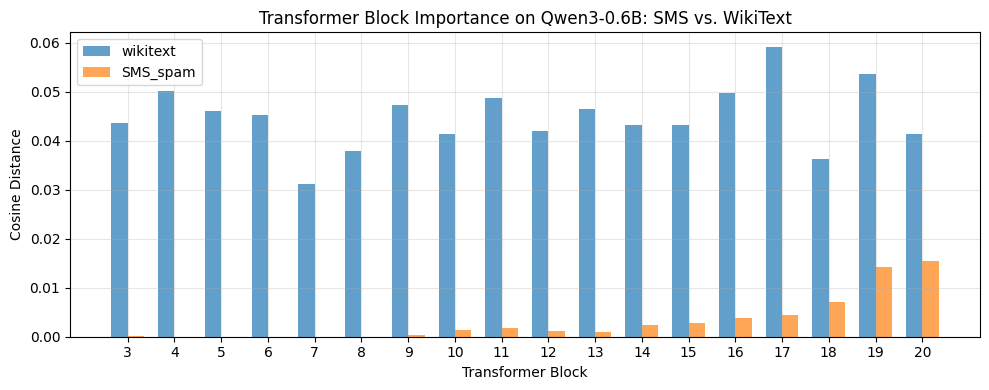

In [29]:
compare_importance(wiki_importance, sms_importance, name1="wikitext", name2="SMS_spam", start=3, end=20)

The results of our comparison reveal a clear pattern. The first layers (0–2) and the last one (27) prove to be important in both datasets, suggesting that they perform fundamental functions, such as the initial processing of the input and the consolidation of the output.

The key difference lies in the behavior of the intermediate layers (roughly 3–26). While in the complex text of Wikitext these layers carry out a measurable job of semantic refinement, in the simple SMS text their contribution is practically null, becoming “passive.” This shows that the importance of a layer varies depending on the complexity of the task, thus validating “depth pruning” as an effective strategy to create more efficient models for specialized tasks.


### Create the pruned model for the SMS dataset by removing the 4 least relevant layers.

We can use the information obtained to remove the less important Transfomer blocks from the model to be used with the SMS Dataset.

In [30]:
from optipfair import prune_model

sms_model, stats = prune_model(
    model=deepcopy(model),
    pruning_type="DEPTH",
    layer_indices=[3, 4, 5, 6],
    show_progress=True,
    return_stats=True
)

Removing layers: 100%|██████████| 28/28 [00:00<00:00, 326223.64it/s]


The new model has only 24 transformer blocks.

In [31]:
print (stats['percentage_reduction'])

10.556796316657504


In [32]:
print(sms_model)

Qwen3ForCausalLM(
  (model): Qwen3Model(
    (embed_tokens): Embedding(151936, 1024)
    (layers): ModuleList(
      (0-23): 24 x Qwen3DecoderLayer(
        (self_attn): Qwen3Attention(
          (q_proj): Linear(in_features=1024, out_features=2048, bias=False)
          (k_proj): Linear(in_features=1024, out_features=1024, bias=False)
          (v_proj): Linear(in_features=1024, out_features=1024, bias=False)
          (o_proj): Linear(in_features=2048, out_features=1024, bias=False)
          (q_norm): Qwen3RMSNorm((128,), eps=1e-06)
          (k_norm): Qwen3RMSNorm((128,), eps=1e-06)
        )
        (mlp): Qwen3MLP(
          (gate_proj): Linear(in_features=1024, out_features=3072, bias=False)
          (up_proj): Linear(in_features=1024, out_features=3072, bias=False)
          (down_proj): Linear(in_features=3072, out_features=1024, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): Qwen3RMSNorm((1024,), eps=1e-06)
        (post_attention_layernorm): Qwe

### Creating WikiModel using optipfair.

In [33]:
from optipfair import analyze_layer_importance, prune_model_depth, prune_model

In [34]:

wiki_scores = analyze_layer_importance(model,
                                       dataloaderwiki,
                                       show_progress=True)

Processing batches: 100%|██████████| 13/13 [00:05<00:00,  2.44it/s]


In [35]:
layers_2_remove = sorted(wiki_scores.keys(), key=lambda x: wiki_scores[x])[:4]
print (layers_2_remove)

[7, 18, 8, 20]


In [36]:
wiki_model = prune_model(
        model=deepcopy(model),
        pruning_type="DEPTH",
        layer_indices=layers_2_remove,
        show_progress=True,
    )

Removing layers: 100%|██████████| 28/28 [00:00<00:00, 337472.74it/s]


In [37]:
wiki_model

Qwen3ForCausalLM(
  (model): Qwen3Model(
    (embed_tokens): Embedding(151936, 1024)
    (layers): ModuleList(
      (0-23): 24 x Qwen3DecoderLayer(
        (self_attn): Qwen3Attention(
          (q_proj): Linear(in_features=1024, out_features=2048, bias=False)
          (k_proj): Linear(in_features=1024, out_features=1024, bias=False)
          (v_proj): Linear(in_features=1024, out_features=1024, bias=False)
          (o_proj): Linear(in_features=2048, out_features=1024, bias=False)
          (q_norm): Qwen3RMSNorm((128,), eps=1e-06)
          (k_norm): Qwen3RMSNorm((128,), eps=1e-06)
        )
        (mlp): Qwen3MLP(
          (gate_proj): Linear(in_features=1024, out_features=3072, bias=False)
          (up_proj): Linear(in_features=1024, out_features=3072, bias=False)
          (down_proj): Linear(in_features=3072, out_features=1024, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): Qwen3RMSNorm((1024,), eps=1e-06)
        (post_attention_layernorm): Qwe